In [246]:
import oda_api.token 
import logging
import numpy as np
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage, OdaLightCurve, OdaSpectrum
import matplotlib.pyplot as plt
import astroquery.heasarc
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib.patches import Circle
from astroquery.jplhorizons import Horizons
import pandas as pd
import astropy.units as u
import json

In [ ]:
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

## SCW ANALYSIS

Load the ScWs.

In [259]:
scw = []
start = []
end = []

with open("../data/Crab-ScWs.txt", "r") as f:
    next(f)
    for line in f:
        parts = line.strip().split(", ")
        scw.append(parts[0])
        start.append(float(parts[1]))  
        end.append(float(parts[2]))  

unique_sorted_data = {}
for scw, start, end in sorted(zip(scw, start, end), key=lambda x: x[0]):
    if scw not in unique_sorted_data:  
        unique_sorted_data[scw] = (scw, start, end)

scw, start, end = map(list, zip(*unique_sorted_data.values()))
durations = [e-s for e,s in zip(end, start)]

Plot distribution of the ScWs over time and the angular seperation between the Crab and the Sun.

In [266]:
crab = SkyCoord.from_name("Crab")
ra = crab.ra.deg
dec = crab.dec.deg
crab_coords = SkyCoord(ra=ra, dec=dec, unit=(u.deg, u.deg))

epochs = {'start':'2003-01-01', 'stop':'2025-01-01', 'step':'31d'}
sun = Horizons(id='sun', location='@0', epochs=epochs) 
eph = sun.ephemerides()
ra_values = eph['RA']
dec_values = eph['DEC']
datetime_values = eph['datetime_jd']

sun_coords = SkyCoord(ra=ra_values, dec=dec_values, unit=(u.deg, u.deg))

In [267]:
angles = sun_coords.separation(crab_coords).deg
dates = pd.date_range(start='2003-01-01', periods=260, freq='M')

yearly_avg = [np.mean(angles[i:i+12]) for i in range(0, len(angles), 12)]
monthly_avg = []
for month in range(12):
    month_indices = [i for i in range(len(angles)) if dates[i].month == month + 1]
    monthly_avg.append(np.mean(angles[month_indices]))
    
print("Yearly Averages:", yearly_avg)
print("Monthly Averages:", monthly_avg)

Yearly Averages: [142.28613478815373, 106.35765153020502, 70.8803876788816, 38.252820677978185, 9.671421004120084, 19.227224516203876, 46.49379157875391, 74.60333863214184, 105.47156878492426, 142.66734311415345, 164.06952319819968, 116.43139343942262, 74.29712550441128, 42.80351759762254, 16.983759040764145, 7.323515297477644, 27.97459881896843, 49.279625740956185, 70.42696370153487, 91.54495818899403, 112.57840019656413, 130.00585024460335]
Monthly Averages: [76.0266407674818, 75.96667133164752, 75.92707403520043, 75.9725546086232, 75.86464765746229, 75.69092164913063, 75.52378598635912, 75.37070264444358, 72.24872861026289, 72.0424380893623, 72.02829034222552, 72.06157092740342]


/tmp/ipykernel_2225/3303049636.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2003-01-01', periods=260, freq='M')


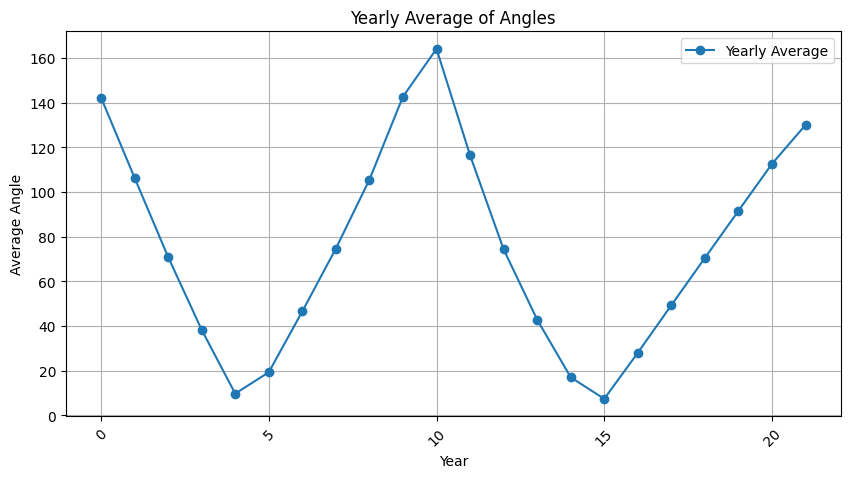

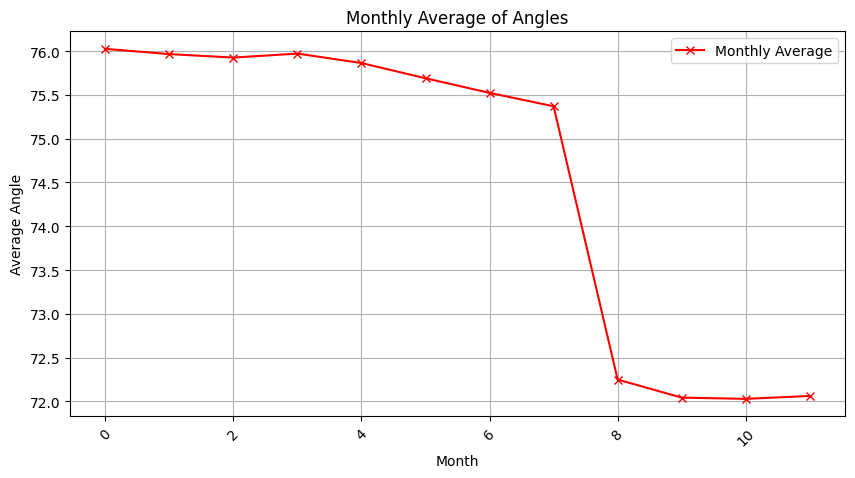

In [268]:
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg, label='Yearly Average', marker='o')
plt.title('Yearly Average of Angles')
plt.xlabel('Year')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(monthly_avg, label='Monthly Average', marker='x', color='r')
plt.title('Monthly Average of Angles')
plt.xlabel('Month')
plt.ylabel('Average Angle')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

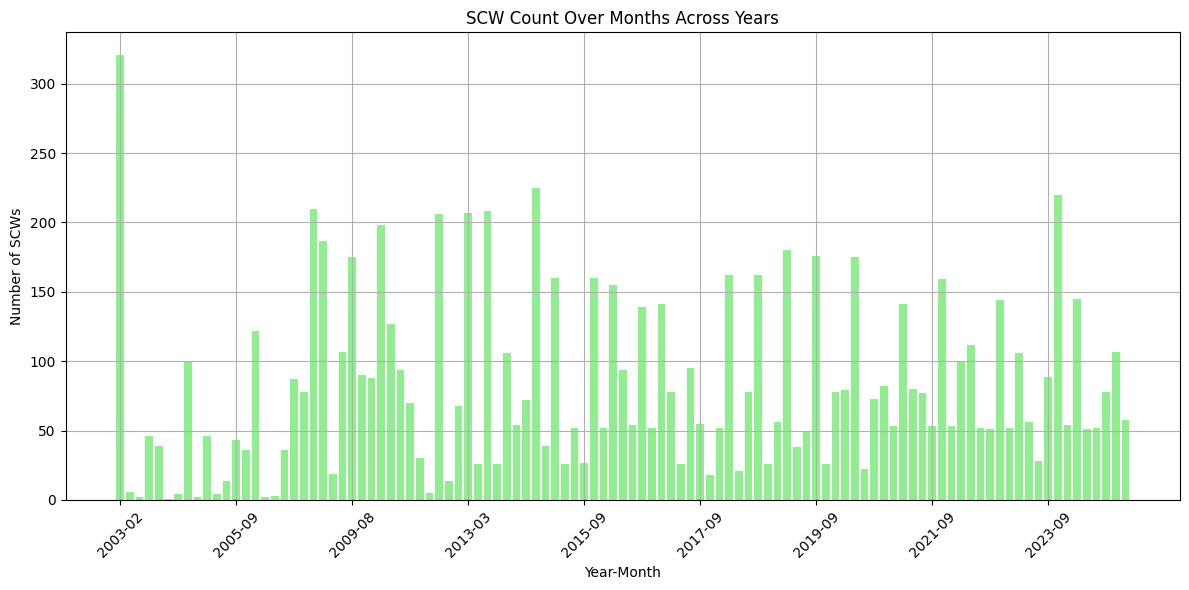

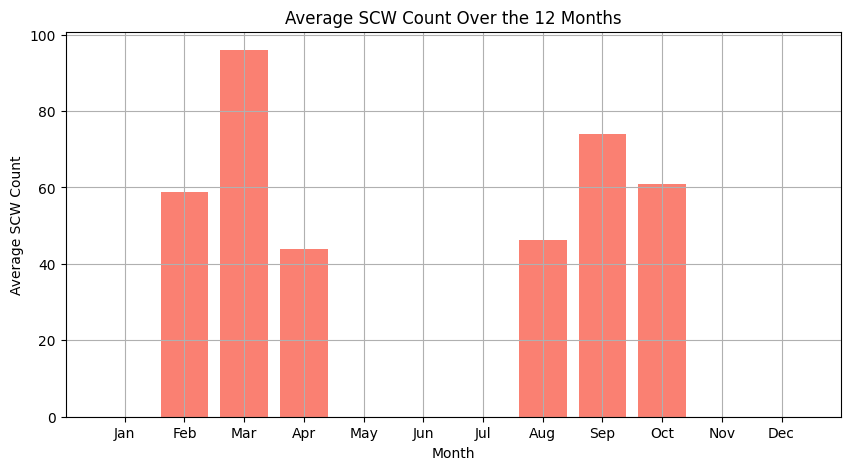

In [269]:
start_dates = [Time(t, format='mjd').datetime for t in start]
years = [date.year for date in start_dates]
months = [date.month for date in start_dates]

year_month = [(year, month) for year, month in zip(years, months)]
year_month_count = pd.Series(year_month).value_counts().sort_index()
year_month_labels = [f'{year}-{month:02d}' for year, month in sorted(year_month_count.index)]
scw_year_month_counts = year_month_count.sort_index().values

yearly_count = {year: years.count(year) for year in set(years)}
monthly_count = {month: months.count(month) for month in range(1, 13)}

years_unique = sorted(yearly_count.keys())
scw_yearly = [yearly_count[year] for year in years_unique]

months_unique = list(range(1, 13))
scw_monthly_avg = [monthly_count[month] / len(years_unique) for month in months_unique]

plt.figure(figsize=(12, 6))
plt.bar(year_month_labels, scw_year_month_counts, color='lightgreen')
plt.title('SCW Count Over Months Across Years')
plt.xlabel('Year-Month')
plt.ylabel('Number of SCWs')
plt.xticks(np.arange(0, len(year_month_labels), 12), labels=[year_month_labels[i] for i in range(0, len(year_month_labels), 12)], rotation=45)
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(10, 5))
plt.bar(months_unique, scw_monthly_avg, color='salmon')
plt.title('Average SCW Count Over the 12 Months')
plt.xlabel('Month')
plt.ylabel('Average SCW Count')
plt.xticks(months_unique, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)


## QUERYING 

As we can see, Crab observations only happen twice per year in 3-month groups (Feb->Apr and Aug->Oct).
The idea now will be to get some longterm lightcurves over the years and see how the countrate evolves. Depending on the variability of the countrate, we will use it for flux conversion.

In [271]:
api_cat={
    "cat_frame": "fk5",
    "cat_coord_units": "deg",
    "cat_column_list": [
        [0],
        ["Crab"],
        [125.4826889038086],
        [ra],
        [dec],
        [-32768],
        [2],
        [0],
        [0.0002800000074785203]],
    "cat_column_names": [
        "meta_ID",
        "src_names",
        "significance",
        "ra",
        "dec",
        "NEW_SOURCE",
        "ISGRI_FLAG",
        "FLAG",
        "ERR_RAD"
    ],
    "cat_column_descr":
        [
            ["meta_ID", "<i8"],
            ["src_names", "<U11"],
            ["significance", "<f8"],
            ["ra", "<f8"],
            ["dec", "<f8"],
            ["NEW_SOURCE", "<i8"],
            ["ISGRI_FLAG", "<i8"],
            ["FLAG", "<i8"],
            ["ERR_RAD", "<f8"]
        ],
    "cat_lat_name": "dec",
    "cat_lon_name": "ra"
}

We use asynchronous querying. We aim to get one result per month, every year. Since the ScWs only happen in two 3-month intervals per year, this will mean 6 results every year for 22 years so 120 results total. 

To choose the ScW every month, we will take the shortest one for time reasons.

In [272]:
isot_start_times = Time(start, format='mjd').isot
isot_end_times = Time(end, format='mjd').isot
duration_seconds = [duration * 86400 for duration in durations]
year_months = [st[:7] for st in isot_start_times]

## IMAGES

In [256]:
disp_by_date = {}
data_by_date = {}

while True:
    image_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30",
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "detection_threshold": "5",
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_image",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
        }
        
        if scw_id not in disp_by_date:
            disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = disp_by_date[scw_id]
        
        data = data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                data_by_date[scw_id] = data

        image_results.append(data)

    n_complete = len([ year for year, _disp in disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(disp_by_date)}")
    if n_complete == len(disp_by_date):
        print("done!")
        break
    print("not done")

found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, public-pool-hpc",
    "sub": "hucklethums@icloud.com"
}
token expires in 237.5 h
token expires in 237.5 h
token expires in 237.5 h
found token in TokenLocation.FILE_CUR_DIR your token payload: {
    "email": "hucklethums@icloud.com",
    "exp": 1742905994,
    "name": "interstellxr",
    "roles": "authenticated user, publi

Is complete  False


- waiting for remote response (since 2025-03-15 16:00:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:00:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:00:57), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: AW8QVID19IP8F4GW job: f1ea9db4df58ba6d
session: AW8QVID19IP8F4GW job: f1ea9db4df58ba6d
session: AW8QVID19IP8F4GW job: f1ea9db4df58ba6d

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: f1ea9db4df58ba6d
... assigned job id: f1ea9db4df58ba6d
... assigned job id: f1ea9db4df58ba6d
 | the job is working remotely, please wait status=submitted job_id=f1ea9db4 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


session: GSWZHFTINMB68B48 job: 4ff00c94ee94c8ae
session: GSWZHFTINMB68B48 job: 4ff00c94ee94c8ae
session: GSWZHFTINMB68B48 job: 4ff00c94ee94c8ae

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 4ff00c94ee94c8ae
... assigned job id: 4ff00c94ee94c8ae
... assigned job id: 4ff00c94ee94c8ae
 | the job is working remotely, please wait status=submitted job_id=4ff00c94 in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4ff00c94 in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4ff00c94 in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: 4TROAHITTME6RMS2 job: cba77d3c19910d39
session: 4TROAHITTME6RMS2 job: cba77d3c19910d39
session: 4TROAHITTME6RMS2 job: cba77d3c19910d39

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: cba77d3c19910d39
... assigned job id: cba77d3c19910d39
... assigned job id: cba77d3c19910d39
 | the job is working remotely, please wait status=submitted job_id=cba77d3c in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=cba77d3c in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=cba77d3c in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: JRO8OQVYIGMN9AS4 job: dc1effa55ef2d212
session: JRO8OQVYIGMN9AS4 job: dc1effa55ef2d212
session: JRO8OQVYIGMN9AS4 job: dc1effa55ef2d212

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: dc1effa55ef2d212
... assigned job id: dc1effa55ef2d212
... assigned job id: dc1effa55ef2d212
 | the job is working remotely, please wait status=submitted job_id=dc1effa5 in 0 messages since 7 seconds (7.2/7.2); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=dc1effa5 in 0 messages since 7 seconds (7.2/7.2); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=dc1effa5 in 0 messages since 7 seconds (7.2/7.2); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: C5JGN74X4F8ZHVIW job: 03176a9d03a2cf14
session: C5JGN74X4F8ZHVIW job: 03176a9d03a2cf14
session: C5JGN74X4F8ZHVIW job: 03176a9d03a2cf14

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 03176a9d03a2cf14
... assigned job id: 03176a9d03a2cf14
... assigned job id: 03176a9d03a2cf14
 | the job is working remotely, please wait status=submitted job_id=03176a9d in 0 messages since 19 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=03176a9d in 0 messages since 19 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=03176a9d in 0 messages since 19 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:01:54), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:01:54), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:01:54), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: BNBW9LF706DNTUEU job: c1f497e80f9080e3
session: BNBW9LF706DNTUEU job: c1f497e80f9080e3
session: BNBW9LF706DNTUEU job: c1f497e80f9080e3

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: c1f497e80f9080e3
... assigned job id: c1f497e80f9080e3
... assigned job id: c1f497e80f9080e3
 | the job is working remotely, please wait status=submitted job_id=c1f497e8 in 0 messages since 18 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


session: REE2OG731HNXMC5I job: 356099eed56d2ffd
session: REE2OG731HNXMC5I job: 356099eed56d2ffd
session: REE2OG731HNXMC5I job: 356099eed56d2ffd

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 356099eed56d2ffd
... assigned job id: 356099eed56d2ffd
... assigned job id: 356099eed56d2ffd
 | the job is working remotely, please wait status=submitted job_id=356099ee in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=356099ee in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=356099ee in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


- waiting for remote response (since 2025-03-15 16:02:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:22), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: GIT12CQCY6NG72FM job: c64e0e4c6406609b
session: GIT12CQCY6NG72FM job: c64e0e4c6406609b
session: GIT12CQCY6NG72FM job: c64e0e4c6406609b

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: c64e0e4c6406609b
... assigned job id: c64e0e4c6406609b
... assigned job id: c64e0e4c6406609b
 | the job is working remotely, please wait status=submitted job_id=c64e0e4c in 0 messages since 9 seconds (9.3/9.3); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: 68L0H93YPE4FCVQY job: 4733ad731fd92bac
session: 68L0H93YPE4FCVQY job: 4733ad731fd92bac
session: 68L0H93YPE4FCVQY job: 4733ad731fd92bac

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 4733ad731fd92bac
... assigned job id: 4733ad731fd92bac
... assigned job id: 4733ad731fd92bac
 | the job is working remotely, please wait status=submitted job_id=4733ad73 in 0 messages since 15 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4733ad73 in 0 messages since 15 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4733ad73 in 0 messages since 15 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:02:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 4YXXO9KM6O1LSAS8 job: dbbc14da281cfa7d
session: 4YXXO9KM6O1LSAS8 job: dbbc14da281cfa7d
session: 4YXXO9KM6O1LSAS8 job: dbbc14da281cfa7d

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: dbbc14da281cfa7d
... assigned job id: dbbc14da281cfa7d
... assigned job id: dbbc14da281cfa7d
 | the job is working remotely, please wait status=submitted job_id=dbbc14da in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


- waiting for remote response (since 2025-03-15 16:02:58), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:58), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:02:58), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: BUBZQXF4UCCH020R job: 8fdbda67c9546ff4
session: BUBZQXF4UCCH020R job: 8fdbda67c9546ff4
session: BUBZQXF4UCCH020R job: 8fdbda67c9546ff4

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 8fdbda67c9546ff4
... assigned job id: 8fdbda67c9546ff4
... assigned job id: 8fdbda67c9546ff4
 | the job is working remotely, please wait status=submitted job_id=8fdbda67 in 0 messages since 8 seconds (8.1/8.1); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: M5ZDF9JJXA6TTPN8 job: a886a9ce7e535755
session: M5ZDF9JJXA6TTPN8 job: a886a9ce7e535755
session: M5ZDF9JJXA6TTPN8 job: a886a9ce7e535755

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: a886a9ce7e535755
... assigned job id: a886a9ce7e535755
... assigned job id: a886a9ce7e535755
 | the job is working remotely, please wait status=submitted job_id=a886a9ce in 0 messages since 12 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a886a9ce in 0 messages since 12 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a886a9ce in 0 messages since 12 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:03:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:19), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 4XTI27B9ZP0FBKFH job: 65a8362336ead632
session: 4XTI27B9ZP0FBKFH job: 65a8362336ead632
session: 4XTI27B9ZP0FBKFH job: 65a8362336ead632

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 65a8362336ead632
... assigned job id: 65a8362336ead632
... assigned job id: 65a8362336ead632
 | the job is working remotely, please wait status=submitted job_id=65a83623 in 0 messages since 8 seconds (8.9/8.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: M0XFM1JHP7R1UOED job: 5d89db53e6f30fc7
session: M0XFM1JHP7R1UOED job: 5d89db53e6f30fc7
session: M0XFM1JHP7R1UOED job: 5d89db53e6f30fc7

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 5d89db53e6f30fc7
... assigned job id: 5d89db53e6f30fc7
... assigned job id: 5d89db53e6f30fc7
 | the job is working remotely, please wait status=submitted job_id=5d89db53 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5d89db53 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5d89db53 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:03:39), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:39), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:39), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 38AVP01QARCAMXEQ job: e9d3df5743bd7242
session: 38AVP01QARCAMXEQ job: e9d3df5743bd7242
session: 38AVP01QARCAMXEQ job: e9d3df5743bd7242

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: e9d3df5743bd7242
... assigned job id: e9d3df5743bd7242
... assigned job id: e9d3df5743bd7242
 | the job is working remotely, please wait status=submitted job_id=e9d3df57 in 0 messages since 8 seconds (8/8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait stat

Is complete  False


- waiting for remote response (since 2025-03-15 16:03:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:03:47), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: YKOQJRCYWPJRAO94 job: 9d760785725e5067
session: YKOQJRCYWPJRAO94 job: 9d760785725e5067
session: YKOQJRCYWPJRAO94 job: 9d760785725e5067

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 9d760785725e5067
... assigned job id: 9d760785725e5067
... assigned job id: 9d760785725e5067
 | the job is working remotely, please wait status=submitted job_id=9d760785 in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: 9JPPCTZWNJ29CIME job: 3d69beda246eace4
session: 9JPPCTZWNJ29CIME job: 3d69beda246eace4
session: 9JPPCTZWNJ29CIME job: 3d69beda246eace4

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 3d69beda246eace4
... assigned job id: 3d69beda246eace4
... assigned job id: 3d69beda246eace4
 | the job is working remotely, please wait status=submitted job_id=3d69beda in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3d69beda in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3d69beda in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: L2IYO9GKDWTHB25F job: 35ac5eccbfc81752
session: L2IYO9GKDWTHB25F job: 35ac5eccbfc81752
session: L2IYO9GKDWTHB25F job: 35ac5eccbfc81752

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 35ac5eccbfc81752
... assigned job id: 35ac5eccbfc81752
... assigned job id: 35ac5eccbfc81752
 | the job is working remotely, please wait status=submitted job_id=35ac5ecc in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=35ac5ecc in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=35ac5ecc in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:04:18), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:04:18), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:04:18), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 88V3A9Z6NXAJJWDD job: 676d0eceb6bcc105
session: 88V3A9Z6NXAJJWDD job: 676d0eceb6bcc105
session: 88V3A9Z6NXAJJWDD job: 676d0eceb6bcc105

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 676d0eceb6bcc105
... assigned job id: 676d0eceb6bcc105
... assigned job id: 676d0eceb6bcc105
 | the job is working remotely, please wait status=submitted job_id=676d0ece in 0 messages since 6 seconds (6.9/6.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: CXGZN5473GTDBPCE job: 68b59a71c47012c7
session: CXGZN5473GTDBPCE job: 68b59a71c47012c7
session: CXGZN5473GTDBPCE job: 68b59a71c47012c7

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 68b59a71c47012c7
... assigned job id: 68b59a71c47012c7
... assigned job id: 68b59a71c47012c7
 | the job is working remotely, please wait status=submitted job_id=68b59a71 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=68b59a71 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=68b59a71 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: L79O8Y709H100SVD job: 4b625160d1c028ec
session: L79O8Y709H100SVD job: 4b625160d1c028ec
session: L79O8Y709H100SVD job: 4b625160d1c028ec

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 4b625160d1c028ec
... assigned job id: 4b625160d1c028ec
... assigned job id: 4b625160d1c028ec
 | the job is working remotely, please wait status=submitted job_id=4b625160 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4b625160 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4b625160 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: EN16BUHADT1N0G2D job: c5c82137b9641e7b
session: EN16BUHADT1N0G2D job: c5c82137b9641e7b
session: EN16BUHADT1N0G2D job: c5c82137b9641e7b

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: c5c82137b9641e7b
... assigned job id: c5c82137b9641e7b
... assigned job id: c5c82137b9641e7b
 | the job is working remotely, please wait status=submitted job_id=c5c82137 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=c5c82137 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=c5c82137 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: O7W6NBT7SU5AEQYO job: dd52ac312e2eb7f6
session: O7W6NBT7SU5AEQYO job: dd52ac312e2eb7f6
session: O7W6NBT7SU5AEQYO job: dd52ac312e2eb7f6

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: dd52ac312e2eb7f6
... assigned job id: dd52ac312e2eb7f6
... assigned job id: dd52ac312e2eb7f6
 | the job is working remotely, please wait status=submitted job_id=dd52ac31 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=dd52ac31 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=dd52ac31 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: XVOT5056FNGXY8RK job: ad008ce41524762b
session: XVOT5056FNGXY8RK job: ad008ce41524762b
session: XVOT5056FNGXY8RK job: ad008ce41524762b

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: ad008ce41524762b
... assigned job id: ad008ce41524762b
... assigned job id: ad008ce41524762b
 | the job is working remotely, please wait status=submitted job_id=ad008ce4 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=ad008ce4 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=ad008ce4 in 0 messages since 8 seconds (8.7/8.7); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: 61RA45KVZS7RCQR6 job: 3dd443a734cb7b4c
session: 61RA45KVZS7RCQR6 job: 3dd443a734cb7b4c
session: 61RA45KVZS7RCQR6 job: 3dd443a734cb7b4c

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 3dd443a734cb7b4c
... assigned job id: 3dd443a734cb7b4c
... assigned job id: 3dd443a734cb7b4c
 | the job is working remotely, please wait status=submitted job_id=3dd443a7 in 0 messages since 9 seconds (9/9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3dd443a7 in 0 messages since 9 seconds (9/9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3dd443a7 in 0 messages since 9 seconds (9/9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating

query 

Is complete  False


session: ZNE0GKVJW6WI3HEE job: 7a66fbfaf81ba49b
session: ZNE0GKVJW6WI3HEE job: 7a66fbfaf81ba49b
session: ZNE0GKVJW6WI3HEE job: 7a66fbfaf81ba49b

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 7a66fbfaf81ba49b
... assigned job id: 7a66fbfaf81ba49b
... assigned job id: 7a66fbfaf81ba49b
 | the job is working remotely, please wait status=submitted job_id=7a66fbfa in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=7a66fbfa in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=7a66fbfa in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: 9S5QYR4CMEV1ILKK job: b561e62bf0924431
session: 9S5QYR4CMEV1ILKK job: b561e62bf0924431
session: 9S5QYR4CMEV1ILKK job: b561e62bf0924431

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: b561e62bf0924431
... assigned job id: b561e62bf0924431
... assigned job id: b561e62bf0924431
 | the job is working remotely, please wait status=submitted job_id=b561e62b in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=b561e62b in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=b561e62b in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: MF8ZPBJRGDTLXISH job: a653fa367abb58e4
session: MF8ZPBJRGDTLXISH job: a653fa367abb58e4
session: MF8ZPBJRGDTLXISH job: a653fa367abb58e4

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: a653fa367abb58e4
... assigned job id: a653fa367abb58e4
... assigned job id: a653fa367abb58e4
 | the job is working remotely, please wait status=submitted job_id=a653fa36 in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a653fa36 in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a653fa36 in 0 messages since 9 seconds (9.5/9.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


- waiting for remote response (since 2025-03-15 16:06:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:10), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: UGWYZ0UL73QIZWLG job: 40b3c0310a72c32e
session: UGWYZ0UL73QIZWLG job: 40b3c0310a72c32e
session: UGWYZ0UL73QIZWLG job: 40b3c0310a72c32e

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 40b3c0310a72c32e
... assigned job id: 40b3c0310a72c32e
... assigned job id: 40b3c0310a72c32e
 | the job is working remotely, please wait status=submitted job_id=40b3c031 in 0 messages since 17 seconds (17/17); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


- waiting for remote response (since 2025-03-15 16:06:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:28), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: TLG7ZQ1GC5PO3A7L job: 72b62fbc013dce14
session: TLG7ZQ1GC5PO3A7L job: 72b62fbc013dce14
session: TLG7ZQ1GC5PO3A7L job: 72b62fbc013dce14

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 72b62fbc013dce14
... assigned job id: 72b62fbc013dce14
... assigned job id: 72b62fbc013dce14
 | the job is working remotely, please wait status=submitted job_id=72b62fbc in 0 messages since 7 seconds (7.9/7.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: ZZGFSUCHX7T2IN2V job: 95918b7307ff78f4
session: ZZGFSUCHX7T2IN2V job: 95918b7307ff78f4
session: ZZGFSUCHX7T2IN2V job: 95918b7307ff78f4

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 95918b7307ff78f4
... assigned job id: 95918b7307ff78f4
... assigned job id: 95918b7307ff78f4
 | the job is working remotely, please wait status=submitted job_id=95918b73 in 0 messages since 16 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=95918b73 in 0 messages since 16 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=95918b73 in 0 messages since 16 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:06:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:06:53), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: CGQ8M0INYKH4T8KJ job: 0dbecf1222bfbc21
session: CGQ8M0INYKH4T8KJ job: 0dbecf1222bfbc21
session: CGQ8M0INYKH4T8KJ job: 0dbecf1222bfbc21

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 0dbecf1222bfbc21
... assigned job id: 0dbecf1222bfbc21
... assigned job id: 0dbecf1222bfbc21
 | the job is working remotely, please wait status=submitted job_id=0dbecf12 in 0 messages since 7 seconds (8/8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait stat

Is complete  False


session: HC6HEXSRO12D39RK job: 740c186324d94484
session: HC6HEXSRO12D39RK job: 740c186324d94484
session: HC6HEXSRO12D39RK job: 740c186324d94484

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 740c186324d94484
... assigned job id: 740c186324d94484
... assigned job id: 740c186324d94484
 | the job is working remotely, please wait status=submitted job_id=740c1863 in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=740c1863 in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=740c1863 in 0 messages since 11 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: 3XELNLDJK09FBVHH job: 8a493149d5059cb8
session: 3XELNLDJK09FBVHH job: 8a493149d5059cb8
session: 3XELNLDJK09FBVHH job: 8a493149d5059cb8

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 8a493149d5059cb8
... assigned job id: 8a493149d5059cb8
... assigned job id: 8a493149d5059cb8
 | the job is working remotely, please wait status=submitted job_id=8a493149 in 0 messages since 27 seconds (28/28); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=8a493149 in 0 messages since 27 seconds (28/28); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=8a493149 in 0 messages since 27 seconds (28/28); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: 9FNA8VURLDGCRZDO job: 1e975af5312824f9
session: 9FNA8VURLDGCRZDO job: 1e975af5312824f9
session: 9FNA8VURLDGCRZDO job: 1e975af5312824f9

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 1e975af5312824f9
... assigned job id: 1e975af5312824f9
... assigned job id: 1e975af5312824f9
 | the job is working remotely, please wait status=submitted job_id=1e975af5 in 0 messages since 14 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=1e975af5 in 0 messages since 14 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=1e975af5 in 0 messages since 14 seconds (15/15); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:07:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:07:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:07:55), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: KAX2SK8MPKA14FJE job: 670a4972ba18ba21
session: KAX2SK8MPKA14FJE job: 670a4972ba18ba21
session: KAX2SK8MPKA14FJE job: 670a4972ba18ba21

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 670a4972ba18ba21
... assigned job id: 670a4972ba18ba21
... assigned job id: 670a4972ba18ba21
 | the job is working remotely, please wait status=submitted job_id=670a4972 in 0 messages since 8 seconds (8.5/8.5); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


session: 7912QCSB3OVDQZKP job: 5f236764243635d5
session: 7912QCSB3OVDQZKP job: 5f236764243635d5
session: 7912QCSB3OVDQZKP job: 5f236764243635d5

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 5f236764243635d5
... assigned job id: 5f236764243635d5
... assigned job id: 5f236764243635d5
 | the job is working remotely, please wait status=submitted job_id=5f236764 in 0 messages since 13 seconds (14/14); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5f236764 in 0 messages since 13 seconds (14/14); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5f236764 in 0 messages since 13 seconds (14/14); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: UJMQ82MHU8C183BK job: f7d8d5f007ac0230
session: UJMQ82MHU8C183BK job: f7d8d5f007ac0230
session: UJMQ82MHU8C183BK job: f7d8d5f007ac0230

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: f7d8d5f007ac0230
... assigned job id: f7d8d5f007ac0230
... assigned job id: f7d8d5f007ac0230
 | the job is working remotely, please wait status=submitted job_id=f7d8d5f0 in 0 messages since 10 seconds (10/10); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=f7d8d5f0 in 0 messages since 10 seconds (10/10); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=f7d8d5f0 in 0 messages since 10 seconds (10/10); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: QN0BLBLXAAB2PY7G job: a868e4cef9a156ae
session: QN0BLBLXAAB2PY7G job: a868e4cef9a156ae
session: QN0BLBLXAAB2PY7G job: a868e4cef9a156ae

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: a868e4cef9a156ae
... assigned job id: a868e4cef9a156ae
... assigned job id: a868e4cef9a156ae
 | the job is working remotely, please wait status=submitted job_id=a868e4ce in 0 messages since 22 seconds (22/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a868e4ce in 0 messages since 22 seconds (22/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=a868e4ce in 0 messages since 22 seconds (22/22); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: 0V6G6LZLK88QLO8X job: 8600238222ba2b26
session: 0V6G6LZLK88QLO8X job: 8600238222ba2b26
session: 0V6G6LZLK88QLO8X job: 8600238222ba2b26

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 8600238222ba2b26
... assigned job id: 8600238222ba2b26
... assigned job id: 8600238222ba2b26
 | the job is working remotely, please wait status=submitted job_id=86002382 in 0 messages since 8 seconds (8.9/8.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=86002382 in 0 messages since 8 seconds (8.9/8.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=86002382 in 0 messages since 8 seconds (8.9/8.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: 3SKL4ZSSIFWZ9GF2 job: 666c4b9ee67e095e
session: 3SKL4ZSSIFWZ9GF2 job: 666c4b9ee67e095e
session: 3SKL4ZSSIFWZ9GF2 job: 666c4b9ee67e095e

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 666c4b9ee67e095e
... assigned job id: 666c4b9ee67e095e
... assigned job id: 666c4b9ee67e095e
 | the job is working remotely, please wait status=submitted job_id=666c4b9e in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=666c4b9e in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=666c4b9e in 0 messages since 7 seconds (7.4/7.4); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: LIVEK73UZWULMR97 job: 045c626668396424
session: LIVEK73UZWULMR97 job: 045c626668396424
session: LIVEK73UZWULMR97 job: 045c626668396424

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 045c626668396424
... assigned job id: 045c626668396424
... assigned job id: 045c626668396424
 | the job is working remotely, please wait status=submitted job_id=045c6266 in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=045c6266 in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=045c6266 in 0 messages since 11 seconds (12/12); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: XYX4F46ZJLRL1OMW job: 724869f7598437dd
session: XYX4F46ZJLRL1OMW job: 724869f7598437dd
session: XYX4F46ZJLRL1OMW job: 724869f7598437dd

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 724869f7598437dd
... assigned job id: 724869f7598437dd
... assigned job id: 724869f7598437dd
 | the job is working remotely, please wait status=submitted job_id=724869f7 in 0 messages since 9 seconds (9.8/9.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=724869f7 in 0 messages since 9 seconds (9.8/9.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=724869f7 in 0 messages since 9 seconds (9.8/9.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


session: J693QLGYKL5AGBK2 job: 2aa8dab455a10e38
session: J693QLGYKL5AGBK2 job: 2aa8dab455a10e38
session: J693QLGYKL5AGBK2 job: 2aa8dab455a10e38

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 2aa8dab455a10e38
... assigned job id: 2aa8dab455a10e38
... assigned job id: 2aa8dab455a10e38
 | the job is working remotely, please wait status=submitted job_id=2aa8dab4 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=2aa8dab4 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=2aa8dab4 in 0 messages since 12 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:09:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:09:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:09:42), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: FVAMPZZBH0J8RFQQ job: 5c365ab8f5d67c6a
session: FVAMPZZBH0J8RFQQ job: 5c365ab8f5d67c6a
session: FVAMPZZBH0J8RFQQ job: 5c365ab8f5d67c6a

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 5c365ab8f5d67c6a
... assigned job id: 5c365ab8f5d67c6a
... assigned job id: 5c365ab8f5d67c6a
 | the job is working remotely, please wait status=submitted job_id=5c365ab8 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


session: 58IA9YNP4VZ0OX6J job: 4f31baf9aebcbc40
session: 58IA9YNP4VZ0OX6J job: 4f31baf9aebcbc40
session: 58IA9YNP4VZ0OX6J job: 4f31baf9aebcbc40

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 4f31baf9aebcbc40
... assigned job id: 4f31baf9aebcbc40
... assigned job id: 4f31baf9aebcbc40
 | the job is working remotely, please wait status=submitted job_id=4f31baf9 in 0 messages since 17 seconds (17/17); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4f31baf9 in 0 messages since 17 seconds (17/17); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4f31baf9 in 0 messages since 17 seconds (17/17); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: ETMT3DNZLVEUHGKE job: 4ffd2e4d0ba3ed26
session: ETMT3DNZLVEUHGKE job: 4ffd2e4d0ba3ed26
session: ETMT3DNZLVEUHGKE job: 4ffd2e4d0ba3ed26

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 4ffd2e4d0ba3ed26
... assigned job id: 4ffd2e4d0ba3ed26
... assigned job id: 4ffd2e4d0ba3ed26
 | the job is working remotely, please wait status=submitted job_id=4ffd2e4d in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4ffd2e4d in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=4ffd2e4d in 0 messages since 8 seconds (8.8/8.8); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: termina

Is complete  False


- waiting for remote response (since 2025-03-15 16:10:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:10:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:10:20), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: IEQX58P5Y12XTJ89 job: 65386cd2980ba79a
session: IEQX58P5Y12XTJ89 job: 65386cd2980ba79a
session: IEQX58P5Y12XTJ89 job: 65386cd2980ba79a

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 65386cd2980ba79a
... assigned job id: 65386cd2980ba79a
... assigned job id: 65386cd2980ba79a
 | the job is working remotely, please wait status=submitted job_id=65386cd2 in 0 messages since 9 seconds (9.9/9.9); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait 

Is complete  False


- waiting for remote response (since 2025-03-15 16:10:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:10:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:10:30), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 43FMMNPEEATKCV5W job: 84e18a459ad203d8
session: 43FMMNPEEATKCV5W job: 84e18a459ad203d8
session: 43FMMNPEEATKCV5W job: 84e18a459ad203d8

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 84e18a459ad203d8
... assigned job id: 84e18a459ad203d8
... assigned job id: 84e18a459ad203d8
 | the job is working remotely, please wait status=submitted job_id=84e18a45 in 0 messages since 15 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


session: 8GV1GW315QL288HU job: 738ba6732e9c805c
session: 8GV1GW315QL288HU job: 738ba6732e9c805c
session: 8GV1GW315QL288HU job: 738ba6732e9c805c

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 738ba6732e9c805c
... assigned job id: 738ba6732e9c805c
... assigned job id: 738ba6732e9c805c
 | the job is working remotely, please wait status=submitted job_id=738ba673 in 0 messages since 15 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=738ba673 in 0 messages since 15 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=738ba673 in 0 messages since 15 seconds (16/16); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:11:02), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:11:02), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2025-03-15 16:11:02), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: 1RUXQV7960G7XKWP job: ea2a3b46d01526d8
session: 1RUXQV7960G7XKWP job: ea2a3b46d01526d8
session: 1RUXQV7960G7XKWP job: ea2a3b46d01526d8

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: ea2a3b46d01526d8
... assigned job id: ea2a3b46d01526d8
... assigned job id: ea2a3b46d01526d8
 | the job is working remotely, please wait status=submitted job_id=ea2a3b46 in 0 messages since 10 seconds (11/11); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait s

Is complete  False


session: PSVRV39PMTZAFK1J job: 5de1d72f73893b2b
session: PSVRV39PMTZAFK1J job: 5de1d72f73893b2b
session: PSVRV39PMTZAFK1J job: 5de1d72f73893b2b

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 5de1d72f73893b2b
... assigned job id: 5de1d72f73893b2b
... assigned job id: 5de1d72f73893b2b
 | the job is working remotely, please wait status=submitted job_id=5de1d72f in 0 messages since 17 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5de1d72f in 0 messages since 17 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=5de1d72f in 0 messages since 17 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: 40PMWSVLZ4JV4ITQ job: d86a82a75f136fca
session: 40PMWSVLZ4JV4ITQ job: d86a82a75f136fca
session: 40PMWSVLZ4JV4ITQ job: d86a82a75f136fca

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: d86a82a75f136fca
... assigned job id: d86a82a75f136fca
... assigned job id: d86a82a75f136fca
 | the job is working remotely, please wait status=submitted job_id=d86a82a7 in 0 messages since 20 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=d86a82a7 in 0 messages since 20 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=d86a82a7 in 0 messages since 20 seconds (20/20); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


session: VIPKUTWOB7H4PWR4 job: fab2703caae36b9a
session: VIPKUTWOB7H4PWR4 job: fab2703caae36b9a
session: VIPKUTWOB7H4PWR4 job: fab2703caae36b9a

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: fab2703caae36b9a
... assigned job id: fab2703caae36b9a
... assigned job id: fab2703caae36b9a
 | the job is working remotely, please wait status=submitted job_id=fab2703c in 0 messages since 13 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=fab2703c in 0 messages since 13 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=fab2703c in 0 messages since 13 seconds (13/13); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
non-waiting dispatcher: terminating
non-waiting dispatcher: terminating
non-waiting dispatcher: terminatin

Is complete  False


- waiting for remote response (since 2025-03-15 16:12:04), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: KIXKSKG9OXPEOXQL job: 3881f70be3be3cc9
session: KIXKSKG9OXPEOXQL job: 3881f70be3be3cc9
session: KIXKSKG9OXPEOXQL job: 3881f70be3be3cc9

... query status prepared => submitted

... query status prepared => submitted

... query status prepared => submitted
... assigned job id: 3881f70be3be3cc9
... assigned job id: 3881f70be3be3cc9
... assigned job id: 3881f70be3be3cc9
 | the job is working remotely, please wait status=submitted job_id=3881f70b in 0 messages since 18 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3881f70b in 0 messages since 18 seconds (18/18); in 0 SCW so far; nodes (0): 0 computed 0 restored
... 
 | the job is working remotely, please wait status=submitted job_id=3881f70b in 0 messages since 18 seconds (18/18); in 0 SCW so far; nodes (0)

Is complete  False


DispatcherException: {'cdci_data_analysis_version': '1.3.5', 'cdci_data_analysis_version_details': 'unknown', 'config': {'dispatcher-config': {'cfg_dict': {'dispatcher': {'bind_options': {'bind_host': '0.0.0.0', 'bind_port': 8000}, 'dispatcher_callback_url_base': 'https://dispatcher-staging-flux.obsuks1.unige.ch', 'dummy_cache': 'dummy-cache', 'email_options': {'bcc_receivers_email_addresses': ['vladimir.savchenko@gmail.com'], 'cc_receivers_email_addresses': [], 'email_sending_job_submitted': True, 'email_sending_job_submitted_default_interval': 1209600, 'email_sending_timeout': True, 'email_sending_timeout_default_threshold': 1, 'sender_email_address': 'postmaster@in.odahub.io', 'smtp_port': 587, 'smtp_server': 'smtp.eu.mailgun.org'}, 'matrix_options': {'matrix_message_sending_job_submitted': True, 'matrix_message_sending_job_submitted_default_interval': 5, 'matrix_message_sending_timeout': True, 'matrix_message_sending_timeout_default_threshold': 1800, 'matrix_server_url': 'https://matrix-client.matrix.org/', 'sentry_for_matrix_message_sending_check': False}, 'product_gallery_options': {'product_gallery_url': 'https://www.astro.unige.ch/mmoda/gallery'}, 'products_url': 'https://www.astro.unige.ch/mmoda/', 'renku_options': {'renku_base_project_url': 'http://renkulab.io/projects', 'renku_gitlab_repository_url': 'git@renkulab.io:astronomy/mmoda/mmoda-request.git', 'ssh_key_path': '/etc/renku-ssh-key'}}}, 'origin': {'filepath': '/dispatcher/conf/conf_env.yml', 'set_by': 'command line /pyenv/versions/3.10.11/lib/python3.10/site-packages/cdci_data_analysis/flask_app/app.py:cdci_data_analysis.flask_app.app'}}, 'plugins': {'cdci_osa_plugin': {'config_file': '/dispatcher/conf/conf.d/osa_data_server_conf.yml'}, 'cdci_polar_plugin': {'config_file': '/dispatcher/conf/conf.d/polar_data_server_conf.yml'}, 'dispatcher_plugin_antares': {'config_file': '/dispatcher/conf/conf.d/antares_data_server_conf.yml'}, 'dispatcher_plugin_gw': {'config_file': '/dispatcher/conf/conf.d/gw_data_server_conf.yml'}, 'dispatcher_plugin_integral_all_sky': {'config_file': '/pyenv/versions/3.10.11/lib/python3.10/site-packages/dispatcher_plugin_integral_all_sky/config_dir/data_server_conf.yml'}, 'dispatcher_plugin_legacysurvey': {'config_file': '/dispatcher/conf/conf.d/legacysurvey_data_server_conf.yml'}, 'dispatcher_plugin_nb2workflow': {'config_file': '/dispatcher/conf/conf.d/nb_data_server_conf.yml'}}}, 'debug_mode': 'no', 'error_message': 'please run connect() first', 'installed_instruments': ['isgri', 'jemx', 'polar', 'antares', 'gw', 'spi_acs', 'legacysurvey', 'aafrag', 'agn_cacades', 'analyse_short_astro_text', 'auger', 'crbeam', 'ctao', 'desi_legacy_survey', 'erosita', 'fermi_lat', 'gaia', 'gallery', 'hess', 'iact_simulators', 'icecube', 'combine_integral_gallery_products', 'integral_gallery_products', 'isgri_expert', 'jemx_expert', 'karabo_dirty_image_sim', 'lightcurve_analysis', 'lst', 'magic', 'meerkat_galaxy_clusters', 'mwa', 'photoz_euclid', 'rosat', 'sed', 'sgwb', 'spectral_analysis', 'stix_mwa_solar_activity', 'synch_ic_brems', 'tool_plot_candidates_pos_photoz', 'wise'], 'message': 'request not valid', 'oda_api_version': '1.2.38'}

Image analysis (extraction of count rates over time).

In [ ]:
data_collection.mosaic_image_0_mosaic.show()
print(data_collection.mosaic_image_0_mosaic.show_meta())
data_collection.dispatcher_catalog_1.table

In [ ]:
im=OdaImage(data_collection)
_ = im.show()
im.write_fits(f"../data/Crab-{scw_pick}")

## LIGHT CURVE

In [ ]:
lc_disp_by_date = {}
lc_data_by_date = {}

while True:
    lightcurve_results = []

    for year_month in set(year_months):

        filtered_scws = []
        for i, year_month_in_list in enumerate(year_months):
            if year_month_in_list == year_month:
                filtered_scws.append((scw[i], isot_start_times[i], isot_end_times[i], duration_seconds[i]))

        if not filtered_scws:
            print(f"No SCWs found for {year_month}")
            continue

        min_duration_scw = min(filtered_scws, key=lambda x: x[3]) # minimum duration
        scw_id, start_time, end_time, duration = min_duration_scw

        par_dict = {
            "RA": ra,
            "DEC": dec,
            "E1_keV": "15",
            "E2_keV": "30", 
            "T_format": "isot",
            'T1': start_time,
            'T2': end_time,
            "time_bin": duration_seconds, 
            "instrument": "isgri",
            "osa_version": "OSA11.2",
            "product": "isgri_lc",
            "product_type": "Real",
            "scw_list": [scw_id],
            'token': oda_api.token.discover_token(),
            'selected_catalog': json.dumps(api_cat)
            }
        
        if scw_id not in lc_disp_by_date:
            lc_disp_by_date[scw_id] = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock", wait=False)
        
        _disp = lc_disp_by_date[scw_id]
        
        data = lc_data_by_date.get(scw_id, None)

        if data is None and not _disp.is_failed:
            if not _disp.is_submitted:
                data = _disp.get_product(**par_dict)
            else:
                _disp.poll()

            print("Is complete ", _disp.is_complete)
            if not _disp.is_complete:
                continue
            else:
                data = _disp.get_product(**par_dict)
                lc_data_by_date[scw_id] = data

        lightcurve_results.append(data)

    n_complete = len([ year for year, _disp in lc_disp_by_date.items() if _disp.is_complete ])
    print(f"complete {n_complete} / {len(lc_disp_by_date)}")
    if n_complete == len(lc_disp_by_date):
        print("done!")
        break
    print("not done")

In [211]:
data_collection.isgri_lc_0_Crab.show()
lc=data_collection._p_list[0]
lc.show()
print(lc.meta_data)
print(lc.data_unit[1].header)

AttributeError: 'DataCollection' object has no attribute 'isgri_lc_0_Crab'

In [ ]:
import oda_api.plot_tools
lc_plot = oda_api.plot_tools.OdaLightCurve(data_collection)
lc_plot.show("Crab", ng_sig_limit=3.0, find_excesses=True)

## IMAGE

Plot from the fits file.

Filename: ../data/Crab-090300900010.001mosaic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  GROUPING      1 BinTableHDU     82   4R x 16C   [8A, 32A, 1J, 1J, 256A, 3A, 32A, 1I, 1I, 1E, 1E, 1E, 1D, 1D, 1D, 1D]   
  2  ISGR-MOSA-IMA    1 ImageHDU        67   (415, 415)   float32   
  3  ISGR-MOSA-IMA    2 ImageHDU        67   (415, 415)   float32   
  4  ISGR-MOSA-IMA    3 ImageHDU        67   (415, 415)   float32   
  5  ISGR-MOSA-IMA    4 ImageHDU        67   (415, 415)   float32   


XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  415                                                  
NAXIS2  =                  415                                                  
PCOUNT  =                   

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55263.868947 from DATE-OBS.
Set MJD-END to 55263.894306 from DATE-END'. [astropy.wcs.wcs]
/tmp/ipykernel_2094/1697405794.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower', aspect='auto')
/tmp/ipykernel_2094/1697405794.py:24: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower', aspect='auto')


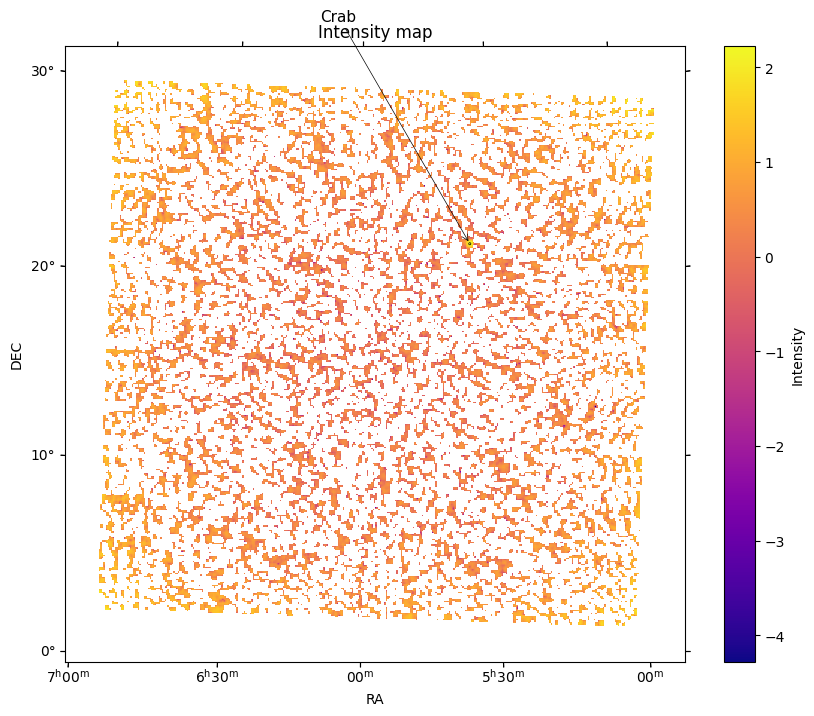

In [18]:
fits_file = f"../data/Crab-{scw_pick}"+"mosaic.fits"

pick = 2  # 2 for image, 3 for variance, 4 for significance and 5 for exposure map

with fits.open(fits_file) as hdul:
    hdul.info()
    intensity_data = hdul[2].data 
    variance_data = hdul[3].data
    significance_data = hdul[4].data
    exposure_data = hdul[5].data
    print("\n")
    print(repr(hdul[pick].header))
    print("\n")
    print(hdul[1].data.columns)
    wcs = WCS(hdul[pick].header)  
    CD1 = np.abs(hdul[pick].header["CD1_1"])

data = [intensity_data, variance_data, significance_data, exposure_data]
image_data = data[pick-2]


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(np.log10(image_data), cmap='plasma', origin='lower', aspect='auto')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

x, y = wcs.all_world2pix(ra, dec, 0)

pixel_scale = CD1 * 3600  # pixel size in arcseconds (|CD1_1| from fits header)
circle_radius_pixels = 7 * 60 / pixel_scale / 2 

circle = Circle((x, y), circle_radius_pixels, edgecolor='black', facecolor='none', lw = 0.5)
ax.add_patch(circle)

ax.annotate(
        text="Crab", 
        xy=(x, y),  
        xytext=(x - 100, y + 150),
        arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
        fontsize=11,
        color="black"
    )

title = ""
if pick == 2:
    title = "Intensity"
elif pick == 3:
    title = "Variance"
elif pick == 4:
    title = "Significance"
elif pick == 5:
    title = "Exposure"

plt.title(title+" map")
plt.colorbar(im, label="Intensity")

plt.savefig(f"../data/Crab-{scw_pick}"+"_"+f"{title}.pdf", format='pdf', bbox_inches='tight')

Countrate to flux conversion (method of E. Jourdain using ISGRI calibration).

Crab count rate: 169.79608 counts/sec
Analytically calculated photon flux: 0.2501898870399915 ph/cm2/s
Numerically calculated photon flux: 0.2502236796064092 ph/cm2/s
Numerically calculated energy flux: 8.296223349642631e-09 erg/cm2/s
Flux per count = energy per photon: 3.315522880445298e-08 erg/photon

To convert countrate to flux, multiply countrate by flux per count: 
Conversion factor: 0.0014736716968529533 for ph/cm2/s or 4.885992229180613e-11 for erg/cm2/s


Text(0, 0.5, 'Flux ($ph.cm^{-2}.s^{-1}/keV$)')

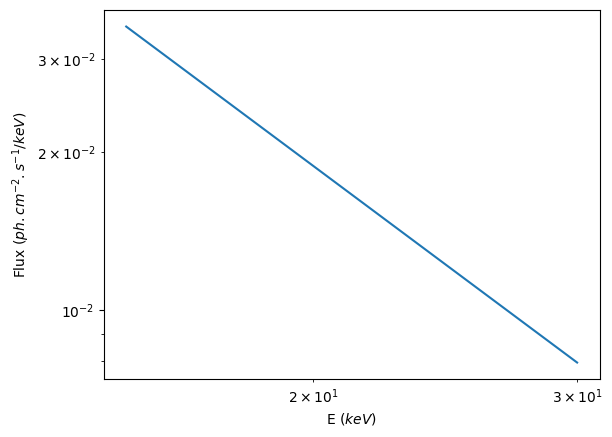

In [19]:
E0 = 100 # 100 keV reference energy
K = 6.2e-4 # flux @ 100 keV (photons/cm2/s), roughly the same for each instrument
E = np.linspace(15, 30)
gamma = 2.12 # photon index of ISGRI (2.105 for SPI+ISGRI+JEM-X)

power_law = K * (E/E0)**(-gamma) # flux

x_int, y_int = int(round(x.item())), int(round(y.item()))

crab_countrate = intensity_data[y_int, x_int]

print("Crab count rate:", crab_countrate, "counts/sec")

ph_flux = - K * (E0)**(gamma) / (gamma-1) * ((30)**(1-gamma) - (15)**(1-gamma)) # analytic
ph_flux_num = np.trapz(power_law, E) # numeric
ph_flux_num_erg = np.trapz(power_law*E*1.60218e-9, E) # numeric, energy units

print(f'Analytically calculated photon flux: {ph_flux} ph/cm2/s')
print(f'Numerically calculated photon flux: {ph_flux_num} ph/cm2/s')
print(f'Numerically calculated energy flux: {ph_flux_num_erg} erg/cm2/s')
print(f'Flux per count = energy per photon: {ph_flux_num_erg/ph_flux_num} erg/photon')
print('\nTo convert countrate to flux, multiply countrate by flux per count:',
      f'\nConversion factor: {ph_flux_num/crab_countrate} for ph/cm2/s or {ph_flux_num_erg/crab_countrate} for erg/cm2/s')

plt.figure()
plt.loglog(E, power_law)
plt.xlabel('E ($keV$)')
plt.ylabel('Flux ($ph.cm^{-2}.s^{-1}/keV$)')